In [1]:
import os 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# launch this cell if you have issues on windows with py4j (think about updating your PATH)
import sys
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

# starts a spark session from notebook

os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=4g  pyspark-shell"
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("load_explore") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/17 12:35:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# loads relevant datas in DataFrames
train_sessions = spark.read.load('../Data/train_sessions.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

train_purchases = spark.read.load('../Data/train_purchases.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

candidate_items = spark.read.load('../Data/candidate_items.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

item_features = spark.read.load('../Data/item_features.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

datas = [train_sessions, train_purchases, candidate_items, item_features]

# Data analysis

In this Noteobook, data from the raw project's dataset will be analysed using map reduce operations.

## Dataset's starting and ending date.

Using map reduce operations, we will computes what are the first and last date of the dataset in the training sessions.

In [3]:
import datetime

def parse_datetime(timestamp):
    try:
        return datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    
max_date = (train_sessions.rdd
            .map(lambda x: (x.session_id, parse_datetime(x.date)))  #  Maps by (session_id, date)
            .reduce(lambda x, y: (x[0], max(x[1], y[1]))))  # Reduces by taking the maximum date (latest)

In [4]:
min_date = (train_sessions.rdd
            .map(lambda x: (x.session_id, parse_datetime(x.date)))  # Maps by (session_id)
            .reduce(lambda x, y: (x[0], min(x[1], y[1]))))  # Reduces by taking the minimum date (earliest)

In [5]:
max_date, min_date

((3, datetime.datetime(2021, 5, 31, 23, 43, 33, 865000)),
 (3, datetime.datetime(2020, 1, 1, 0, 0, 1, 359000)))

## Count the number of distinct (feature_category, feature_value) pairs

In [6]:
unique_item_pairs = (
    item_features
    .rdd
    .map(lambda x: (x.item_id, (x.feature_category_id, x.feature_value_id)))  # Maps by (item_id, (feature_cat, feautr_val)
    .mapValues(lambda x: (set([(x[0], x[1])])))  # Puts the values inside the sets
    .reduce(lambda x, y: (x[0], x[1].union(y[1])))  # Groups the sets togheter. By definition of a set, no (feature_cat, feature_val) duplicates can exists within the sets. 
)

In [7]:
len(unique_item_pairs[1])

904

# Analysis of purchases depending on the period of the purchase.

Let's see the difference of item purchases depending of the weekday, month and season of the sessions.

In [40]:
import numpy as np

time_parsed_purchases = (
    train_purchases.rdd
    .map(lambda x: (x.item_id, parse_datetime(x.date)))  # Maps the purchases with the item as key and the parsed date value
).cache()  # Saves it into primary memory

maximum_item_id = time_parsed_purchases.reduce(lambda x, y: max(x, y))[0]
print(f'Maximum item id found: {maximum_item_id}')

weekend_purchases = (
    time_parsed_purchases
    .filter(lambda x: x[1].weekday() >= 5)  # Checks wherever the day is during a weekend by checking the weekday of the parsed date
)

weekday_purchases = (
    time_parsed_purchases
    .filter(lambda x: x[1].weekday() < 5)  # Checks whever the day is out of weekends.
)

# Computes an histogram of purchases
weekend_purchases_array = np.array(weekend_purchases.map(lambda x: x[0]).collect())
weekday_purchases_array = np.array(weekday_purchases.map(lambda x: x[0]).collect())

def compute_normalized_histogram(data, n_bins=maximum_item_id):
    array = np.zeros(n_bins, dtype=np.float32)
    # Counts every values
    uniques, counts = np.unique(data, return_counts=True)
    # Sets the values for each present item
    for u, c in zip(uniques, counts):
        array[u-1] = c
    # Computes the norm of the histogram    
    total = np.sum(counts)
    return array / total

weekend_histogram = compute_normalized_histogram(weekend_purchases_array, n_bins=maximum_item_id)
weekday_histogram = compute_normalized_histogram(weekday_purchases_array, n_bins=maximum_item_id)

Maximum item id found: 28143


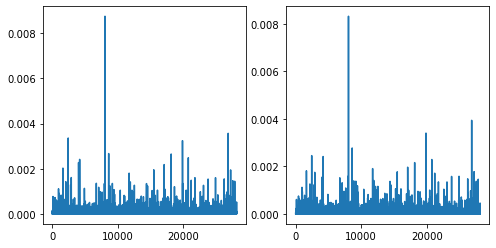

In [65]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(weekend_histogram)
plt.subplot(122)
plt.plot(weekday_histogram)

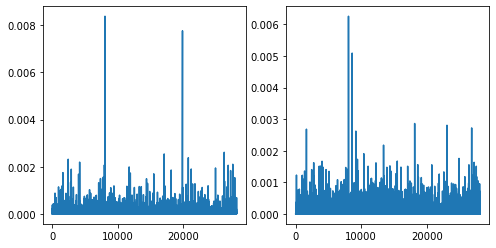

In [68]:
def get_season(date_time):
    season = (date_time.month - 1) // 3
    season += (date_time.month == 3)&(date_time.day>=20)
    season += (date_time.month == 6)&(date_time.day>=21)
    season += (date_time.month == 9)&(date_time.day>=23)
    season -= 3*int(((date_time.month == 12)&(date_time.day>=21)))
    return season

winter_purchases = (
    time_parsed_purchases
    .filter(lambda x: get_season(x[1]) == 0)  # Checks wherever the day is during a weekend by checking the weekday of the parsed date
)

summer_purchases = (
    time_parsed_purchases
    .filter(lambda x: get_season(x[1]) == 2)  # Checks wherever the day is during a weekend by checking the weekday of the parsed date
)


winter_histogram = compute_normalized_histogram(np.array(winter_purchases.map(lambda x: x[0]).collect()), n_bins=maximum_item_id)
summer_histogram = compute_normalized_histogram(np.array(summer_purchases.map(lambda x: x[0]).collect()), n_bins=maximum_item_id)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(winter_histogram)
plt.subplot(122)
plt.plot(summer_histogram)

# Analysis of purchases depending on the the session duration.

Let's analyse the distribution of session durations.

In [94]:
def parse_timestamp_iterable(iterable):
    parsed_dates = []
    found_purchase_date = False
    for timestamp in iterable:
        if not found_purchase_date:
            purchase_date = parse_datetime(timestamp[1])
            parsed_dates.append(purchase_date)
            found_purchase_date = True
        date = parse_datetime(timestamp[0])
        parsed_dates.append(date)
    return sorted(parsed_dates)

mapped_purchases = (
    train_purchases.rdd
    .map(lambda x: (x.session_id, x.date))  # Maps the purchases to a (key=session, value=date) tuple
)

sessions_with_all_dates = (
    train_sessions.rdd
    .map(lambda x: (x.session_id, x.date))  # Maps the sessions to a (key=session, value=visit_date) tuple
    .join(mapped_purchases)  # Joins the purchases, obtaining a (key=session, value=[visit_date, purchase_date]) 
    .groupByKey()  # Groups the sessions altogheter
    .mapValues(parse_timestamp_iterable)  # Parses the dates and puts the purchase date with all the other dates.
)

In [115]:
def find_session_length(values):
    first_date = min(values)
    last_date = max(values)
    return (last_date - first_date).seconds

session_lengths = (
    sessions_with_all_dates
    .mapValues(find_session_length)  # Finds the first and the last date, then computes the difference in seconds
)

In [116]:
session_length_array = np.array(session_lengths.map(lambda x: x[1]).collect())
session_id_array = np.array(session_lengths.map(lambda x: x[0]).collect())

In [117]:
values, counts = np.unique(session_length_array, return_counts=True)

distribution_array = np.zeros(values.max() + 1, dtype=np.int32)

for val, count in zip(values, counts):
    distribution_array[val] = count

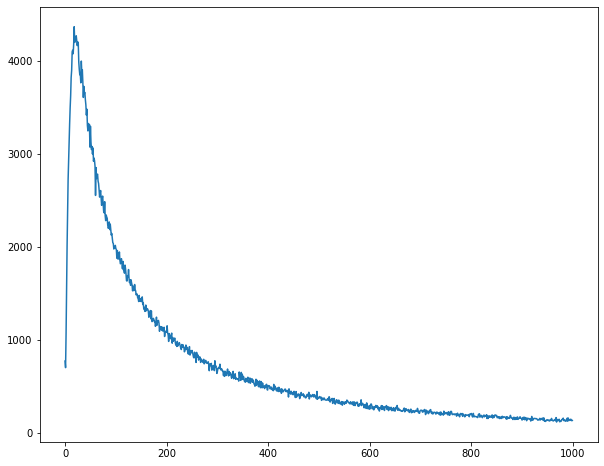

In [133]:
plt.figure(figsize=(10, 8))
plt.plot(distribution_array[0:1000])

In [132]:
values[np.argmax(counts)]

18